In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import cmath
import pickle as pkl
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
from ellipse import LsqEllipse

In [2]:
'''
Ctrl+C, Ctrl+V
Using this files:
Al_III_Daria_last_try_5_8_6_3_resonators_on_power.pkl
STS_FROM_POWER, 30.11.20_raw_data.pkl
STS Probe qubit_raw_data.pkl
'''

'\nCtrl+C, Ctrl+V\nUsing this files:\nAl_III_Daria_last_try_5_8_6_3_resonators_on_power.pkl\nSTS_FROM_POWER, 30.11.20_raw_data.pkl\nSTS Probe qubit_raw_data.pkl\n'

# Reflection coefficient with enviroment

$
S_{21} = 
a \cdot e^{i \alpha} \cdot e^{i 2 \pi f \tau} \cdot 
\left(
1 - \frac{\Gamma_1}{2 \Gamma_2} \cdot
\frac{1 + i \frac{\delta \omega}{\Gamma_2}}
{1 + \left( \frac{\delta \omega}{\Gamma_2} \right)^2 + \frac{\Omega^2}{\Gamma_1 \Gamma_2}} e^{i \phi}
\right) =
a \cdot e^{i \alpha} \cdot e^{i 2 \pi f \tau} \cdot 
\left(
1 - r \cdot (1 + i t) e^{i \phi}
\right)
$

$$
\delta \omega = \frac{f_r - f}{\Gamma_2}, \quad \gamma = \frac{\Gamma_1}{2 \Gamma_2}, \quad R = \frac{\Omega^2}{\Gamma_1 \Gamma_2}, 
\quad t = \frac{\delta \omega}{\Gamma_2}, \quad 
r = \frac{\Gamma_1}{2 \Gamma_2} \cdot 
\frac{1}{1 + \left( \frac{\delta \omega}{\Gamma_2} \right)^2 + \frac{\Omega^2}{\Gamma_1 \Gamma_2}} =
\gamma \cdot \frac{1}{1 + t^2 + R}
$$


$
Re(S_{21}) = 1 - r \cos{\phi} + r t \sin{\phi}
$

$
Im(S_{21}) = -r \sin{\phi} -r t \cos{\phi}
$

$
Abs(S_{21}) = \sqrt{1 + 2 r (t \sin{\phi} - \cos{\phi}) + r^2 (1 + t^2)}
$

$
Arg(S_{21}) = \alpha + 2 \pi f \tau + 
\arctan \left( - \frac{t \cos{\phi} + \sin{\phi}}{\frac{1}{r} + (t \sin{\phi} - \cos{\phi})} \right)
$

# Canonical coordinates

$
S_{21}^* = \frac{\Gamma_1}{2 \Gamma_2} \cdot
\frac{1 + i \frac{\delta \omega}{\Gamma_2}}
{1 + \left( \frac{\delta \omega}{\Gamma_2} \right)^2 + \frac{\Omega^2}{\Gamma_1 \Gamma_2}} e^{i \phi} =
r \cdot (1 + i t) e^{i \phi}
$

$
Arg(S_{21}^*) = \phi + \arctan(t)
$

$
S_{21}^0 = \frac{\Gamma_1}{2 \Gamma_2} \cdot
\frac{1 + i \frac{\delta \omega}{\Gamma_2}}
{1 + \left( \frac{\delta \omega}{\Gamma_2} \right)^2 + \frac{\Omega^2}{\Gamma_1 \Gamma_2}} = 
r \cdot (1 + i t)
$

$
Arg(S_{21}^0) = \arctan(t)
$

# Ellipse fit idea

$
Re(S_{21}^0) = r = A_x \cdot (\cos(\tau) - 1)
$

$
Im(S_{21}^0) = r t = A_y \sin(\tau)
$

$
A_x = \frac{1}{2} \frac{\gamma}{1 + R}, \quad A_y = \frac{1}{2} \frac{\gamma}{\sqrt{1 + R}}
$

# Real part fit idea

$
Re S_{21}^0 = r = \gamma \frac{1}{1 + R + t^2} = \frac{\gamma}{1 + R} \frac{1}{1 + (\frac{t^2}{\sqrt{1 + R}})^2} = \\
= \frac{1}{{1 + \left( \frac{\delta \omega}{\Gamma_2} \right)^2 + \frac{\Omega^2}{\Gamma_1 \Gamma_2}}}
$

$HWHM = \sqrt{1 + R}$

In [3]:
def RMSE(y, f):
        RMSE = np.sqrt(np.mean(np.square(np.subtract(y, f))))
        return RMSE

def delete_big_arg(freq, arg):
    new_freq, new_arg = [], []
    for i in range(len(freq)):
        if abs(arg[i]) <= np.pi/4:
            new_freq.append(freq[i])
            new_arg.append(arg[i])
    return np.array(new_freq), np.array(new_arg)

def delete_noise(x, f):
    q25, q75 = np.percentile(f, [25, 75])
    q50 = np.percentile(f, 50)
    IQR = q75 - q25
    max_f = q75 + 1.5*IQR
    min_f = q25 - 1.5*IQR
    new_x = []
    new_f = []
    for i in range(len(x)):
        if (f[i] >= min_f) and (f[i] <= max_f): 
            new_x.append(x[i])
            new_f.append(f[i])
    return np.array(new_x), np.array(new_f)

In [49]:
class Data(object):
    def __init__(self,
                 is_file=False, file_path=None, is_number=False, freq_var=0,
                 is_data=False, power = None, data=None, freq = None,
                 is_gnrt=False, gnrt_freq=None, gnrt_function=None, gnrt_power=[0]):
        if ((is_file and is_data) or
            (is_data and is_gnrt) or
            (is_gnrt and is_file)):
            print('Error: Can not create such class Data')
        else:
            self.is_file, self.is_data, self.is_gnrt = is_file, is_data, is_gnrt
            self.freq_r, self.gamma1, self.gamma2, self.rabi_freq, self.tau, self.phi, self.a, self.alpha = \
            [], [], [], [], [], [], [], []
            
            self.index_left, self.index_right = [], []
            
            if is_file:
                with open(file_path, 'rb') as file:
                    row_data = pkl.load(file)
                if is_number:
                    freq_vars = row_data[0]
                    self.power = np.array(row_data[1])
                    self.freq = np.array(row_data[2][freq_vars[freq_var]][0][0])
                    self.data = np.array([row_data[2][freq_vars[freq_var]][i][1]
                                          for i in range(len(self.power))])
                else:
                    self.freq, self.power = row_data['Frequency [Hz]'], row_data['power [dBm]']
                    self.data = np.array(row_data['data'])
                    
            if is_data:
                self.freq, self.power = freq, power
                self.data = np.array(data)
    
            if is_gnrt:
                self.freq, self.power = gnrt_freq, gnrt_power
                if gnrt_function == None:
                    self.freq_r, self.gamma1, self.gamma2, self.rabi_freq, self.tau, self.phi, self.a, self.alpha = \
                    5.14072e+09, 5.45783e+06, 1.65725e+06, 6.89639817e+06, 5.237952e-08, 0.05, 1.3062e-02, 1.6840e+03
                    t = (self.freq_r - self.freq)/self.gamma2
                    r = ((self.gamma1/(2*self.gamma2))*1/((1 + t**2 + self.rabi_freq**2/(self.gamma1*self.gamma2))))
                    #function = a*np.exp(1j*alpha)*np.exp(-2*np.pi*1j*self.freq*tau)*(1 - r*(1 + 1j*t)*np.exp(-1j*phi))
                    function = (r*(1 + 1j*t)*np.exp(1j*phi))
                self.data = np.array([function])
            self.real, self.imag = self.data.real, self.data.imag
            self.abs, self.arg = abs(self.data),  np.unwrap([[cmath.phase(self.data[i][j]) 
                                     for j in range(len(self.freq))] 
                                     for i in range(len(self.data))])
    
    def presentation(self, cut=-1, is_fit=False):
        try:
            plt.subplot(2, 2, 1)
            if is_fit: popt, pcov = self.fit_abs(cut=cut, is_plot=True)
            else: plt.plot(self.freq, self.abs[cut])
            plt.subplot(2, 2, 2)
            if is_fit: popt, pcov = self.fit_arg(cut=cut, is_plot=True)
            else: plt.plot(self.freq, self.arg[cut])
            plt.subplot(2, 2, 3)
            plt.plot(self.real[cut], self.imag[cut])
            if self.is_gnrt:
                i_freq_r = 0
                for i in range(len(self.freq)): 
                    if self.freq[i] < self.freq_r: continue
                    else: i_freq_r = i; break
                plt.scatter(self.real[cut][i_freq_r], self.imag[cut][i_freq_r])
                print(self.real[cut][i_freq_r], self.imag[cut][i_freq_r])
            if is_fit:
                popt, pcov = self.fit_abs(cut=cut, is_plot=False)
                def Abs(freq, freq_r, phi, gamma1, gamma2, a, rabi_freq):
                    t = (freq_r - freq)/gamma2
                    r = ((gamma1/(2*gamma2))*1/((1 + t**2 + rabi_freq**2/(gamma1*gamma2))))
                    return a*np.sqrt(1 - 2*r*(np.cos(phi) - t*np.sin(phi)) + (r**2)*(1 + t**2))
                abs_data = Abs(self.freq, *popt)
                popt, pcov = self.fit_arg(cut=cut, is_plot=False)
                def Arg(freq, freq_r, phi, gamma1, gamma2, alpha, rabi_freq, tau):
                    t = (freq_r - freq) / gamma2
                    r = ((gamma1 / (2 * gamma2)) * 1 / ((1 + t ** 2 + rabi_freq ** 2 / (gamma1 * gamma2))))
                    return alpha + 2*np.pi*freq*tau + np.arctan(-(t*np.cos(phi) + np.sin(phi))/(1/r + t*np.sin(phi) - np.cos(phi)))
                arg_data = Arg(self.freq, *popt)
                data = abs_data*np.exp(1j*arg_data)
                plt.plot(data.real, data.imag)
            plt.subplot(2, 2, 4)
            plt.plot(self.freq, self.real[cut])
            plt.show()
        except: return
        
    def HM_indexes(self, y):
        HM = (max(y) + min(y))/2
        index_left = 0
        index_right = len(y) - 1
        while (y[index_left] > HM and index_left < len(y) - 1): index_left += 1
        while (y[index_right] > HM and index_right > 0): index_right -= 1
        return min(index_left, index_right), max(index_left, index_right)
    
    def FM_indexes(self, y):
        HM = (max(y) + min(y))/2
        index_left = 0
        index_right = len(y) - 1
        while (y[index_left] > HM and index_left < len(y) - 1): index_left += 1
        while (y[index_right] > HM and index_right > 0): index_right -= 1
        index_left, index_right = min(index_left, index_right), max(index_left, index_right)
        delta = int((index_right - index_left)/2)
        index_left -= delta
        index_right += delta
        return index_left, index_right
    
    def pi_quoter_indexes(self, y):
        pi_quoter = np.pi/4
        index_left = len(y) - 1
        index_right = 0
        while (y[index_left] < pi_quoter and index_left > 0): index_left -= 1
        while (y[index_right] > -pi_quoter and index_right < len(y) - 1): index_right += 1
        return min(index_left, index_right), max(index_left, index_right)

    def HWHM(self, x, y):
        index_left, index_right = np.array(self.HM_indexes(y))
        return (x[index_right] - x[index_left])/2
    
    
    def fit_abs(self, cut=-1, is_plot=False):
        x, y = self.freq, self.abs[cut]
        if is_plot: plt.plot(x, y)

        def  Lorentzian(x, x_0, alpha, gamma, y_0):
            return y_0 + (alpha/(gamma*np.pi)) * (1/(((x - x_0)/gamma)**2 + 1))
        hwhm = self.HWHM(self.freq, self.abs[cut])
        p0 = [x.mean(), (max(y) - min(y))*np.pi*hwhm, hwhm, max(y)]
        popt, pcov = curve_fit(Lorentzian, x, y, p0 = p0)
        #if is_plot: plt.plot(x, Lorentzian(x, *popt), label='Lorentzian')
        
        def Abs(freq, freq_r, phi, gamma1, gamma2, a, rabi_freq):
            t = (freq_r - freq)/gamma2
            r = ((gamma1/(2*gamma2))*1/((1 + t**2 + rabi_freq**2/(gamma1*gamma2))))
            return a*np.sqrt(1 - 2*r*(np.cos(phi) - t*np.sin(phi)) + (r**2)*(1 + t**2))
        freq_r, gamma, a = popt[0], popt[2], popt[3]
        p0 = [freq_r, 0, gamma, gamma, a, gamma]
        popt, pcov = curve_fit(Abs, x, y, p0=p0, maxfev=100000)
        if is_plot: plt.plot(x, Abs(x, *popt), label='S_21')
        
        if is_plot: plt.legend()        
            
        return popt, pcov
        

    def fit_arg(self, cut=-1, is_plot=False):
        x, y = self.freq, self.arg[cut]
        if is_plot: plt.plot(x, y)
        
        def linear(x, a, b): return a*x + b
        popt, pcov = curve_fit(linear, x, y)
        #if is_plot: plt.plot(x, linear(x, *popt), label='linear')
            
        def Arg(freq, freq_r, phi, gamma1, gamma2, alpha, rabi_freq, tau):
            t = (freq_r - freq) / gamma2
            r = ((gamma1 / (2 * gamma2)) * 1 / ((1 + t ** 2 + rabi_freq ** 2 / (gamma1 * gamma2))))
            return (alpha + (2*np.pi*freq*tau) + 
                    np.arctan(-(t*np.cos(phi) + np.sin(phi))/(1/r + t*np.sin(phi) - np.cos(phi))))
        tau, alpha = popt[0], popt[1]
        hwhm = self.HWHM(self.freq, self.abs[cut])
        popt, pcov = self.fit_abs(cut=cut, is_plot=False)
        freq_r, phi, gamma1, gamma2, rabi_freq = popt[0], popt[1], hwhm, hwhm, 1
        p0 = [freq_r, phi, gamma1, gamma2, alpha, rabi_freq, tau/(2*np.pi)]
        popt, pcov = curve_fit(Arg, x, y, p0=p0, maxfev=100000)
        if is_plot: plt.plot(x, Arg(x, *popt), label='S_21')
        
        if is_plot: plt.legend()
        
        return popt, pcov
    
    
            
    def canonical_Data(self):
        new_data = []
        tmp_power = []
        tmp_index_left = []
        tmp_index_right = []
        for cut in range(len(self.power)):
            try:
                index_left, index_right = self.FM_indexes(self.abs[cut])
                popt, pcov = self.fit_abs(cut=cut)
                freq_r, a = popt[0], popt[-2]
                popt, pcov = self.fit_arg(cut=cut)
                alpha, tau = popt[-3], popt[-1]

                self.freq_r.append(freq_r)
                self.a.append(a)
                self.alpha.append(alpha)
                self.tau.append(tau)
                tmp_power.append(self.power[cut])
                tmp_index_left.append(index_left)
                tmp_index_right.append(index_right)
                new_data.append(-(self.data[cut] / (a*np.exp(1j*alpha)*np.exp(1j*2*np.pi*self.freq*tau)) - 1))
            except: continue
        
        new_Data = Data(is_data=True, power=tmp_power, data=new_data, freq=self.freq)
        new_Data.freq_r = self.freq_r
        new_Data.a = self.a
        new_Data.alpha = self.alpha
        new_Data.tau = self.tau
        new_Data.index_left = tmp_index_left
        new_Data.index_right = tmp_index_right
        return new_Data
    
    def fit_canonical_arg(self, cut=-1, is_plot=False):
        x, y = self.freq, self.arg[cut]
        if is_plot: plt.plot(x, y)
        
        def arg(freq, phi, gamma2): return phi + np.arctan((self.freq_r[cut] - freq)/gamma2)
        ids = np.arange(self.index_left[cut], self.index_right[cut])
        popt, pcov = curve_fit(arg, x[ids], y[ids])
        if is_plot: plt.plot(x, arg(x, *popt))
        
        return popt, pcov
    
    def delete_impendance_mismatch(self, is_plot=False):
        new_data = []
        tmp_power = []
        tmp_index_left = []
        tmp_index_right = []
        for cut in range(len(self.power)):
            try:
                popt, pcov = self.fit_canonical_arg(cut)
                phi, gamma2 = popt[0], popt[1]
                
                self.freq_r.append(self.freq_r[cut])
                self.a.append(self.a[cut])
                self.alpha.append(self.alpha[cut])
                self.tau.append(self.tau[cut])
                self.gamma2.append(gamma2)
                self.phi.append(phi)
                tmp_power.append(self.power[cut])
                tmp_index_left.append(self.index_left[cut])
                tmp_index_right.append(self.index_right[cut])
                new_data.append(self.data[cut] / np.exp(1j*phi))
            except: continue
        
        new_Data = Data(is_data=True, power=tmp_power, data=new_data, freq=self.freq)
        new_Data.freq_r = self.freq_r
        new_Data.a = self.a
        new_Data.alpha = self.alpha
        new_Data.tau = self.tau
        new_Data.gamma2 = self.gamma2
        new_Data.phi = self.phi
        new_Data.index_left = tmp_index_left
        new_Data.index_right = tmp_index_right
        return new_Data
                
    def fit_phase(self, cut=-1, is_plot=False):
        x, y = self.freq, self.arg[cut]
        if is_plot: plt.plot(x, y)
        
        def linear(x, x_0, gamma): 
            return (x_0 - x)*gamma
        def arctan(x, x_0, gamma): 
            return np.arctan((x_0 - x)*gamma)
        index_left, index_right = self.pi_quoter_indexes(y)
        #index_left, index_right = self.index_left[cut], self.index_right[cut] 
        indexes = np.arange(index_left, index_right)
        x_0, gamma = self.freq_r[cut], 1/(x[self.index_left[cut]] - x[self.index_right[cut]]) 
        p0 = [x_0, gamma]
        #popt, pcov = curve_fit(linear, x[indexes], np.tan(y[indexes]), p0=p0, maxfev=100000)
        #if is_plot: plt.plot(x[indexes], np.arctan(linear(x[indexes], *popt)))
        popt, pcov = curve_fit(arctan, x[indexes], y[indexes], p0=p0, maxfev=100000)
        if is_plot: plt.plot(x[indexes], arctan(x[indexes], *popt))
        
        return popt, pcov
                
    def fit_ellipse(self, cut=-1, is_plot=False):
        y, x = self.real[cut], self.imag[cut]
        if is_plot: plt.plot(y, x)
        
        def ellipse(x, a, b):
            return a*(1 + np.sqrt(1 - (x/b)**2))
        index_left, index_right = self.pi_quoter_indexes(self.arg[cut])
        indexes = np.arange(index_left, index_right)
        #indexes = np.arange(self.index_left[cut], self.index_right[cut])
        a, b = max(y)/2, (max(x) - min(x))/2
        p0 = [a, b]
        popt, pcov = curve_fit(ellipse, x[indexes], y[indexes], p0=p0)
        if is_plot:
            a, b = abs(popt)
            t = np.linspace(-np.pi, np.pi, 1000)
            plt.plot(y[indexes], x[indexes])
            plt.plot(a*(np.cos(t) + 1), b*np.sin(t), c='r')
            
        return popt, pcov

# Import data

In [178]:
d = Data(is_file=True, file_path='STS_FROM_POWER, 30.11.20_raw_data.pkl', is_number=False, freq_var=4)
#d = Data(is_file=True, file_path='Al_III_Daria_last_try_5_8_6_3_resonators_on_power.pkl', is_number=True, freq_var=4)
#for cut in range(len(d.power)): d.presentation(cut = cut, is_fit=True)

# Transformation to canonical coordinates

### Abs fit made in two steps:
1) Prepearing initial guess with lorentzian fit 

2) Full model fit

### Arg fit made in two steps:
1) Prepearing initial guess with linear function fit 

2) Full model fit

$$$$

This two fits gives $f_r, a, \alpha, \tau$

In [179]:
cd = d.canonical_Data()

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


# Fit canonical arg
This fit gives $\gamma_2, \phi$

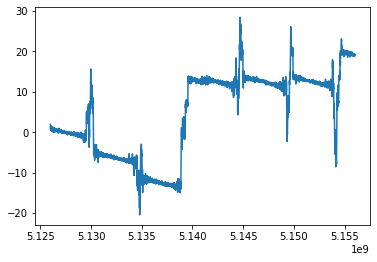

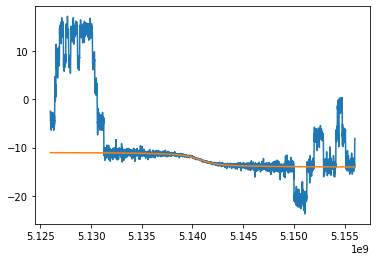

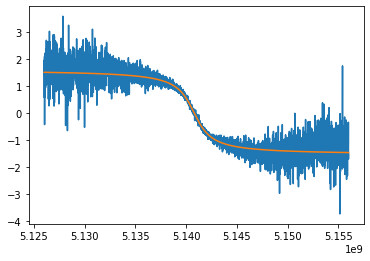

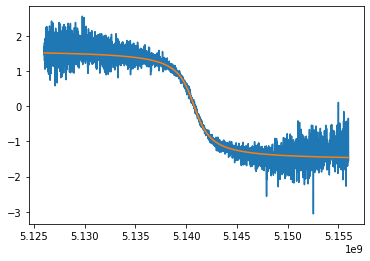

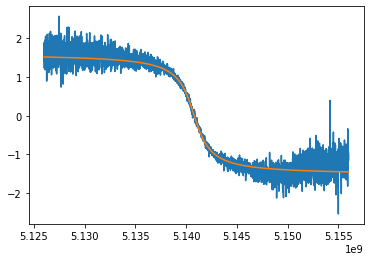

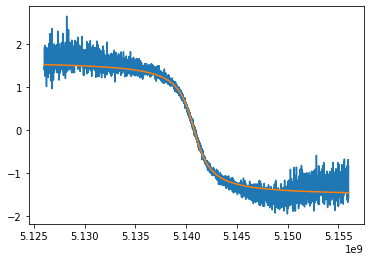

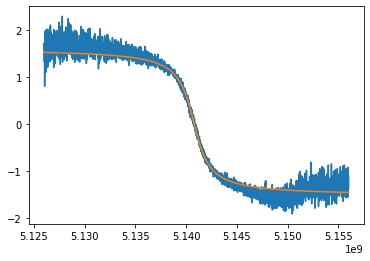

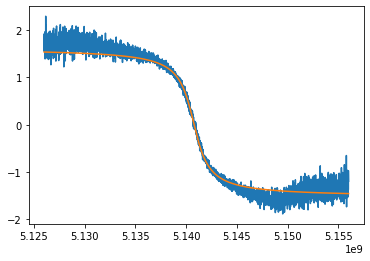

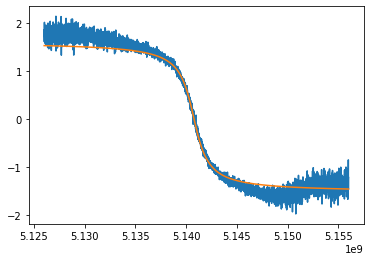

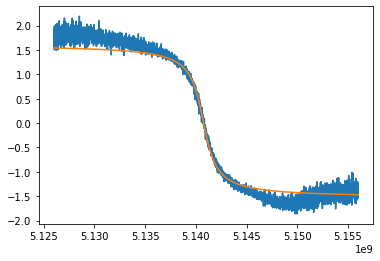

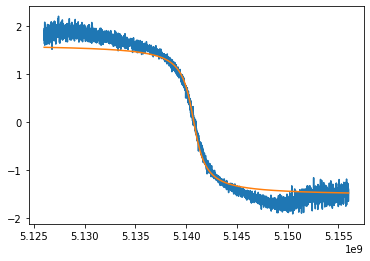

In [180]:
P, G_2 = [], []
for cut in range(len(cd.power)):
    try:
        popt, pcov = cd.fit_canonical_arg(cut=cut, is_plot=True)
        G_2.append(popt[1])
        P.append(cd.power[cut])
    except: plt.show()
    plt.show()

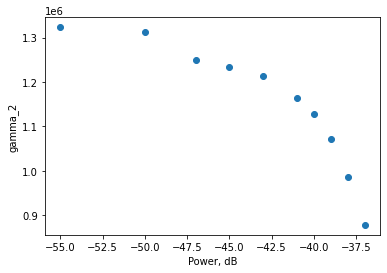

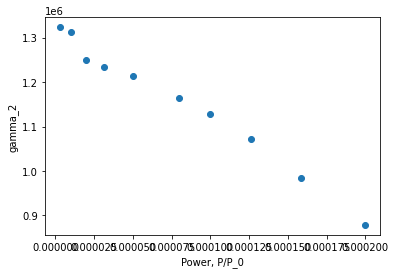

In [182]:
P, G_2 = np.array(P), np.array(G_2)
ids = range(0, len(P))

plt.scatter(P[ids], G_2[ids])
plt.xlabel('Power, dB')
plt.ylabel('gamma_2')
plt.show()

plt.scatter(10.**(0.1*P[ids]), G_2[ids])
plt.xlabel('Power, P/P_0')
plt.ylabel('gamma_2')
plt.show()

# Delete impedance mismatch

In [183]:
imd = cd.delete_impendance_mismatch()

In [184]:
P, G_2 = [], []
for cut in range(len(imd.power)):
    try:
        popt, pcov = imd.fit_canonical_arg(cut=cut, is_plot=False)
        G_2.append(popt[1])
        P.append(imd.power[cut])
    except: plt.show()
    plt.show()

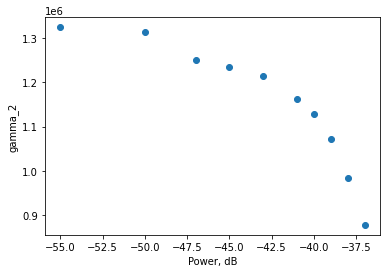

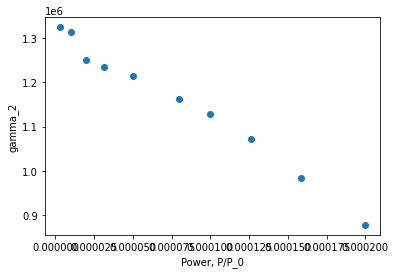

In [185]:
P, G_2 = np.array(P), np.array(G_2)
ids = range(0, len(P))

plt.scatter(P[ids], G_2[ids])
plt.xlabel('Power, dB')
plt.ylabel('gamma_2')
plt.show()

plt.scatter(10.**(0.1*P[ids]), G_2[ids])
plt.xlabel('Power, P/P_0')
plt.ylabel('gamma_2')
plt.show()

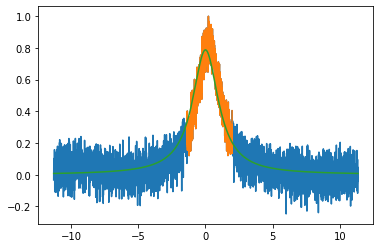

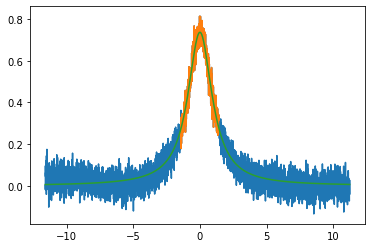

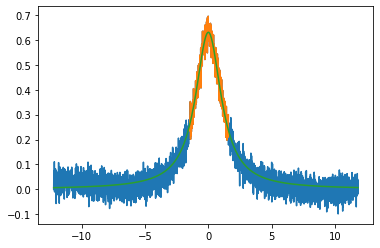

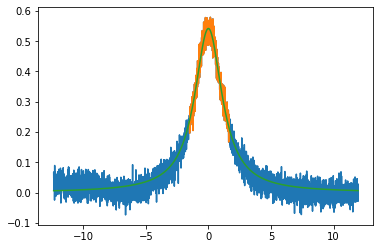

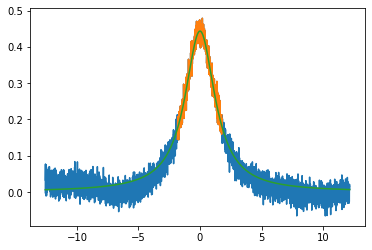

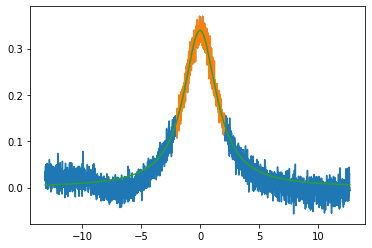

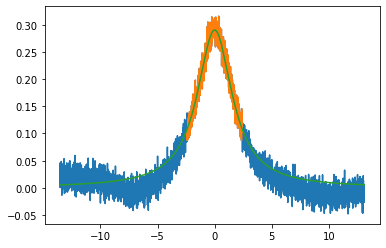

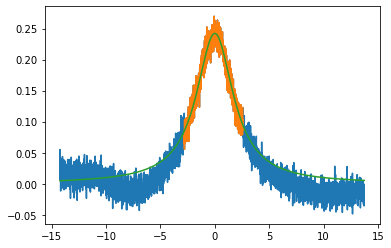

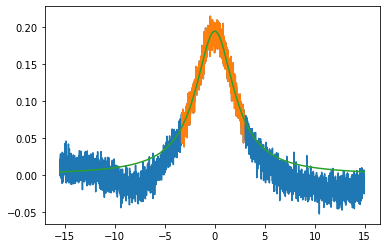

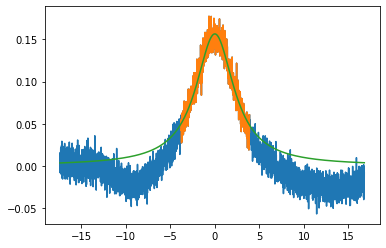

In [186]:
def lor(x, gamma, R): return gamma/(1 + R + x**2)
def linear(x, a, b): return a*x + b
    
G, Rabi, P = [], [], []

for cut in range(len(imd.power)):
    x, y = np.array(imd.freq), np.array(imd.real[cut])
    t = (imd.freq_r[cut] - x)/imd.gamma2[cut]
    
    l, r = imd.HM_indexes(-y)
    ids = range(l, r)
    
    plt.plot(t, y)
    plt.plot(t[ids], y[ids])
    
    HWHM = t[r] - t[l]
    R = (HWHM**2 - 1)
    gamma = max(y)*(1 + R)
    p0 = (gamma, R)
    popt, pcov = curve_fit(lor, t[ids], y[ids], p0=p0)
    
    plt.plot(t, lor(t, *popt))
    plt.show()
    
    G.append(popt[0])
    Rabi.append(popt[1])
    P.append(imd.power[cut])

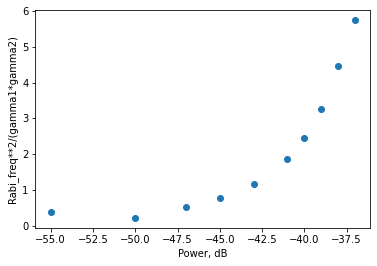

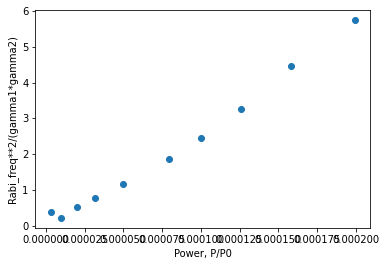

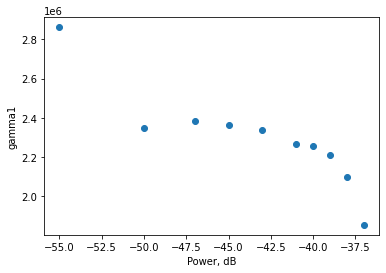

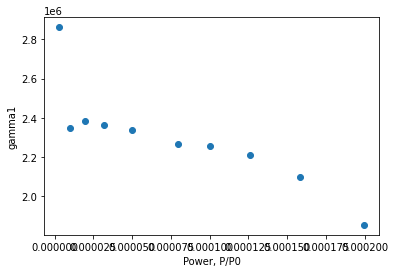

In [187]:
G, Rabi, P = np.array(G), np.array(Rabi), np.array(P)
ids = range(0, len(P))

plt.scatter(P[ids], Rabi[ids])
plt.xlabel('Power, dB')
plt.ylabel('Rabi_freq**2/(gamma1*gamma2)')
plt.show()

plt.scatter(10.**(0.1*P[ids]), Rabi[ids])
plt.xlabel('Power, P/P0')
plt.ylabel('Rabi_freq**2/(gamma1*gamma2)')
plt.show()

plt.scatter(P[ids], G[ids]*2*np.array(imd.gamma2)[ids])
plt.xlabel('Power, dB')
plt.ylabel('gamma1')
plt.show()

plt.scatter(10.**(0.1*P[ids]), G[ids]*2*np.array(imd.gamma2)[ids])
plt.xlabel('Power, P/P0')
plt.ylabel('gamma1')
plt.show()


# Import data

In [153]:
d = Data(is_file=True, file_path='STS_FROM_POWER, 30.11.20_raw_data.pkl', is_number=False, freq_var=4)
d = Data(is_file=True, file_path='Al_III_Daria_last_try_5_8_6_3_resonators_on_power.pkl', is_number=True, freq_var=4)
#for cut in range(len(d.power)): d.presentation(cut = cut, is_fit=True)

# Transformation to canonical coordinates

### Abs fit made in two steps:
1) Prepearing initial guess with lorentzian fit 

2) Full model fit

### Arg fit made in two steps:
1) Prepearing initial guess with linear function fit 

2) Full model fit

$$$$

This two fits gives $f_r, a, \alpha, \tau$

In [154]:
cd = d.canonical_Data()

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


# Fit canonical arg
This fit gives $\gamma_2, \phi$

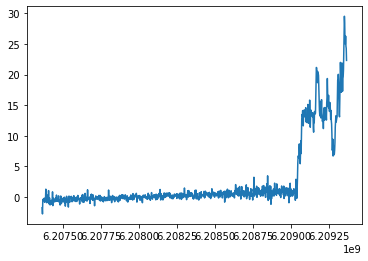

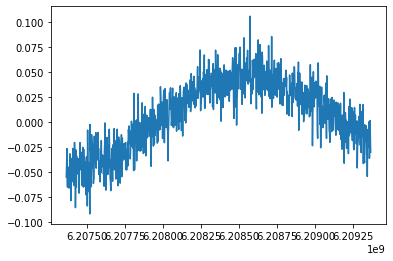

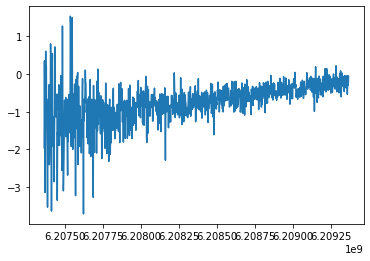

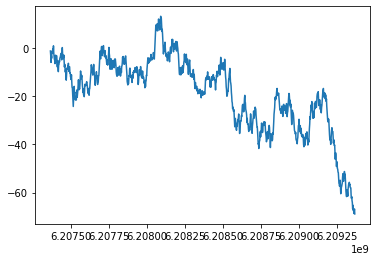

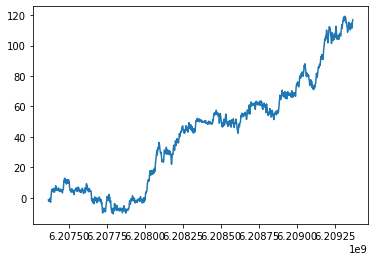

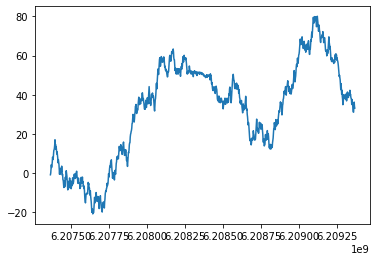

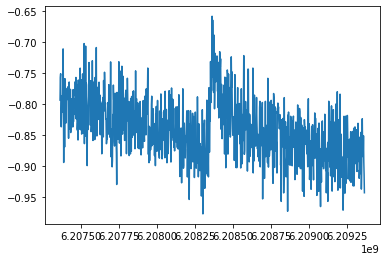

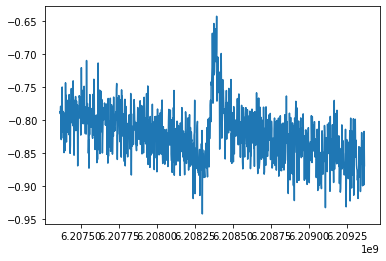

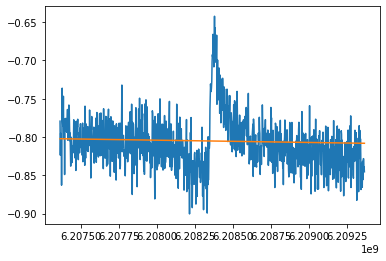

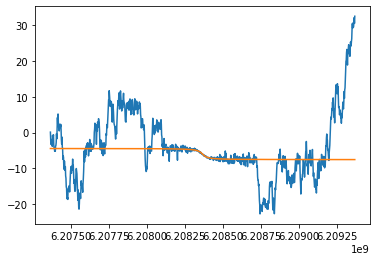

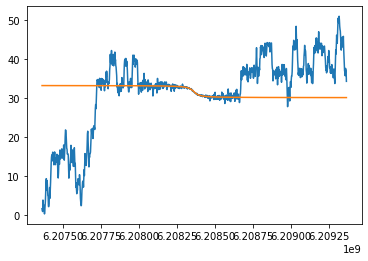

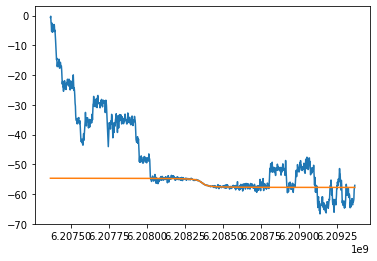

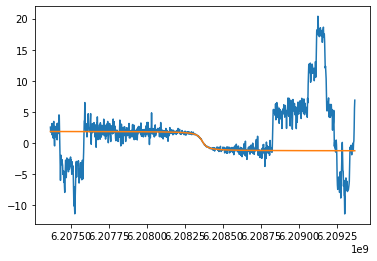

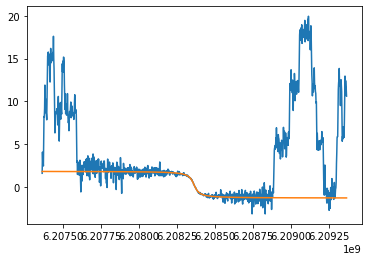

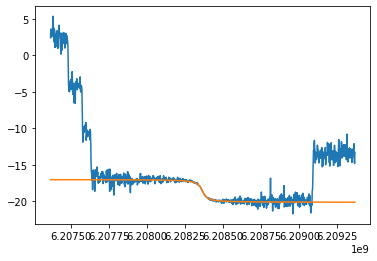

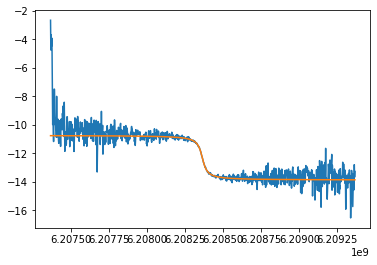

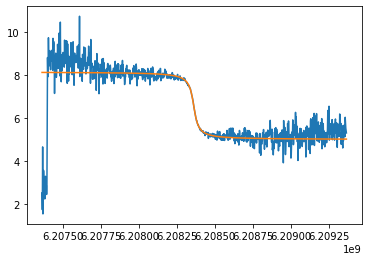

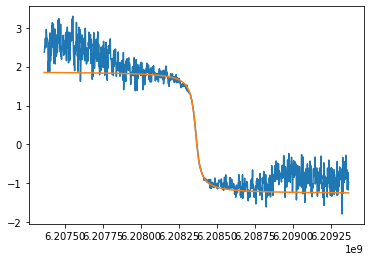

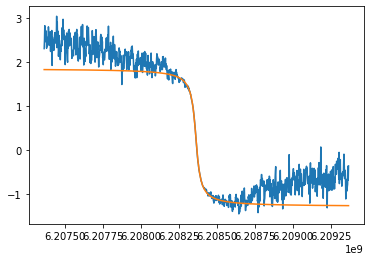

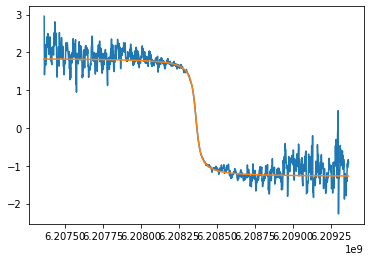

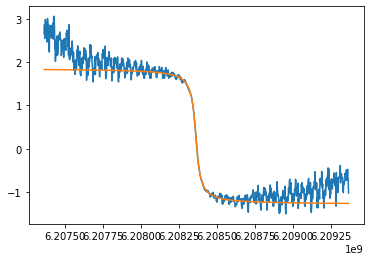

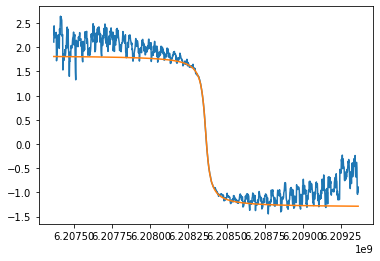

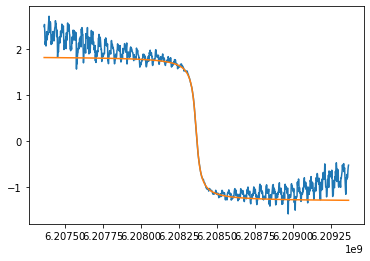

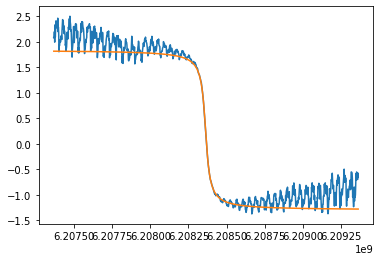

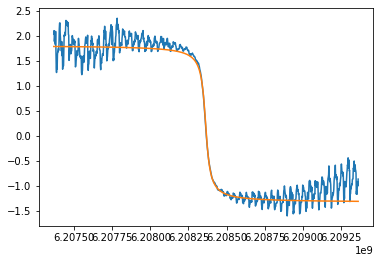

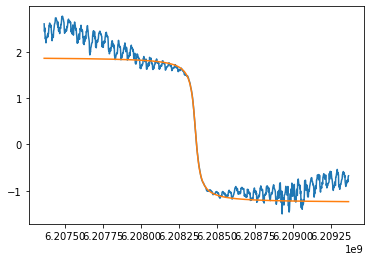

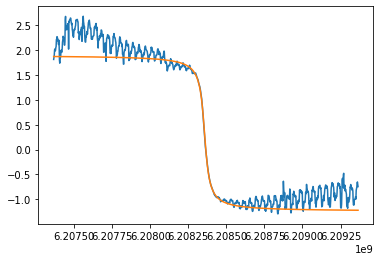

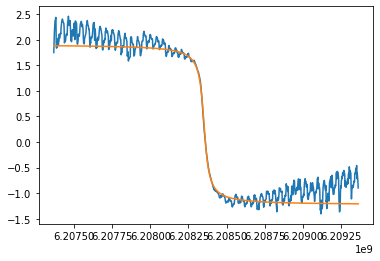

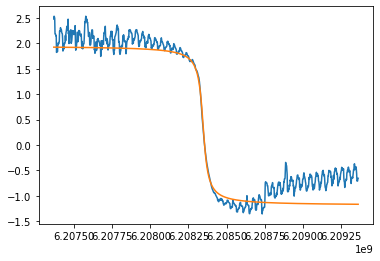

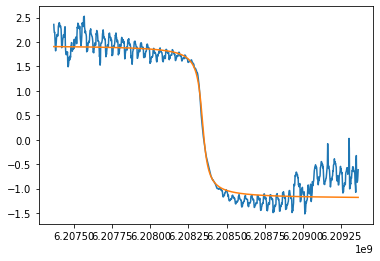

In [155]:
P, G_2 = [], []
for cut in range(len(cd.power)):
    try:
        popt, pcov = cd.fit_canonical_arg(cut=cut, is_plot=True)
        G_2.append(popt[1])
        P.append(cd.power[cut])
    except: plt.show()
    plt.show()

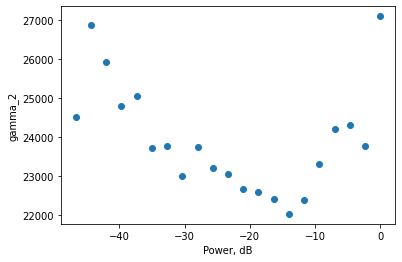

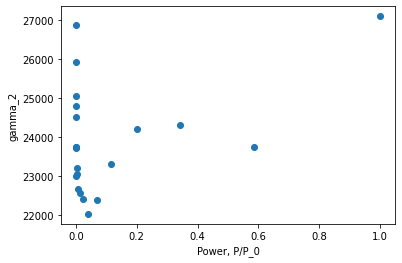

In [158]:
P, G_2 = np.array(P), np.array(G_2)
ids = range(1, len(P))

plt.scatter(P[ids], G_2[ids])
plt.xlabel('Power, dB')
plt.ylabel('gamma_2')
plt.show()

plt.scatter(10.**(0.1*P[ids]), G_2[ids])
plt.xlabel('Power, P/P_0')
plt.ylabel('gamma_2')
plt.show()

# Delete impedance mismatch

In [159]:
imd = cd.delete_impendance_mismatch()

In [164]:
P, G_2 = [], []
for cut in range(len(imd.power)):
    try:
        popt, pcov = imd.fit_canonical_arg(cut=cut, is_plot=False)
        G_2.append(popt[1])
        P.append(imd.power[cut])
    except: plt.show()
    plt.show()

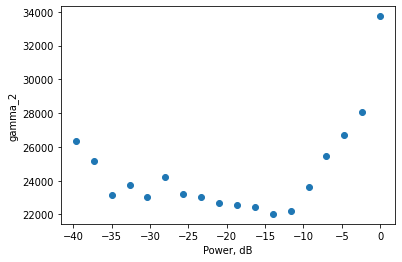

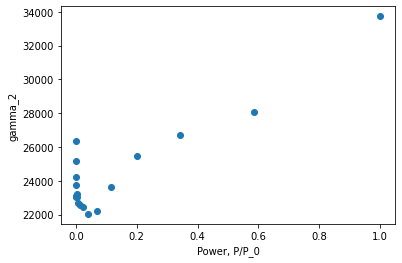

In [171]:
P, G_2 = np.array(P), np.array(G_2)
ids = range(4, len(P))

plt.scatter(P[ids], G_2[ids])
plt.xlabel('Power, dB')
plt.ylabel('gamma_2')
plt.show()

plt.scatter(10.**(0.1*P[ids]), G_2[ids])
plt.xlabel('Power, P/P_0')
plt.ylabel('gamma_2')
plt.show()

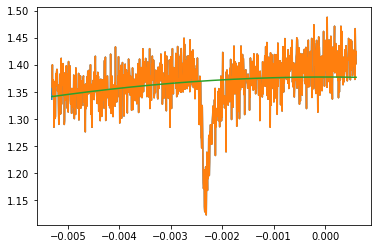

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


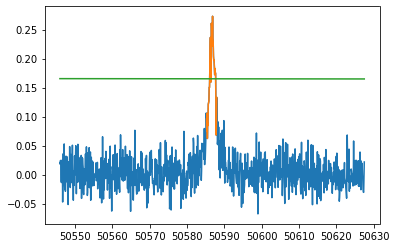

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


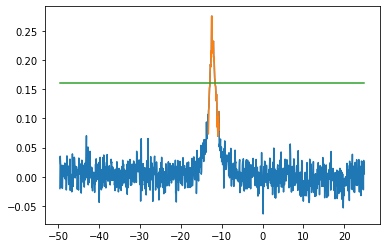

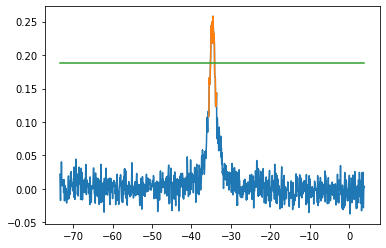

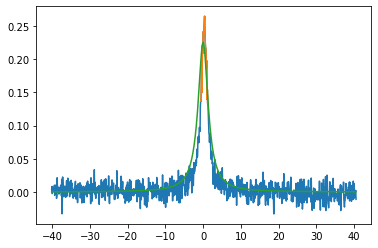

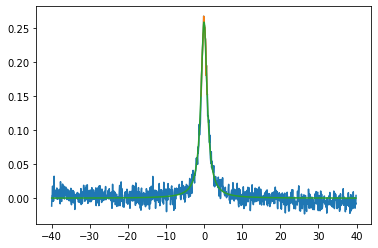

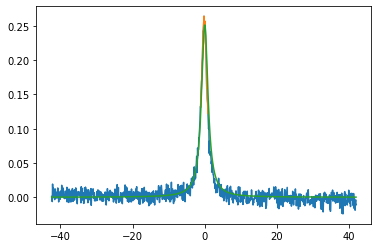

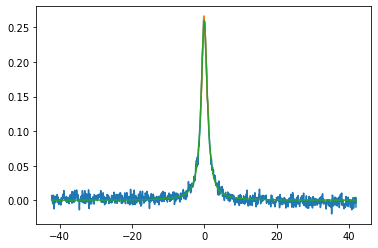

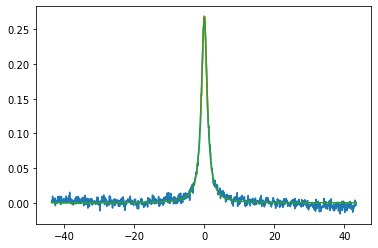

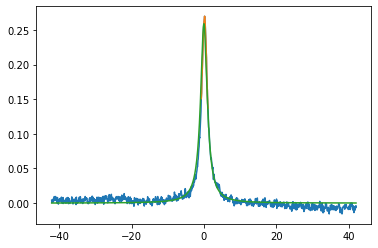

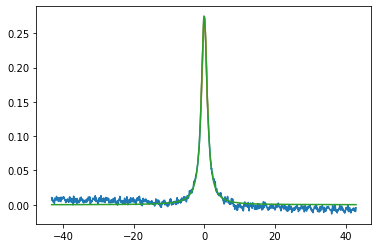

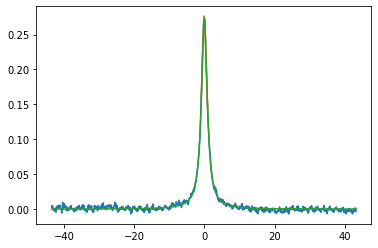

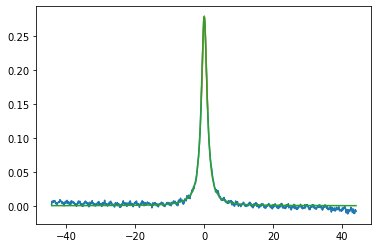

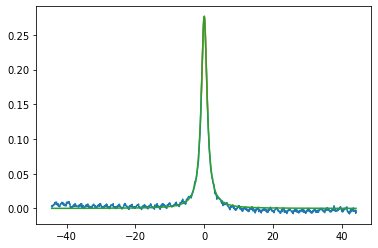

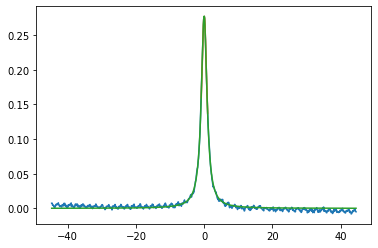

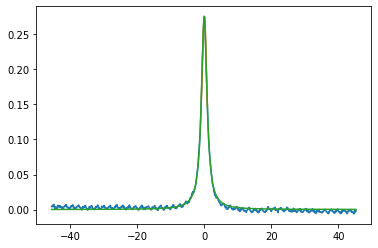

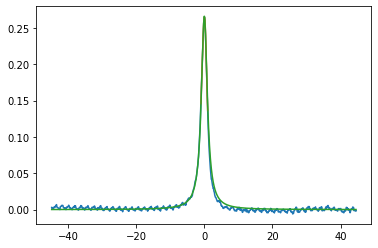

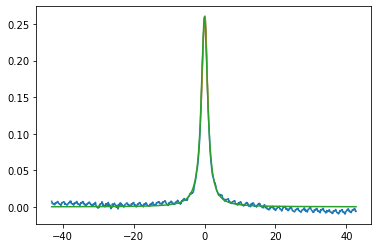

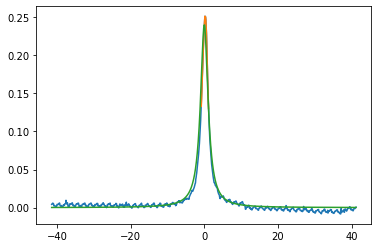

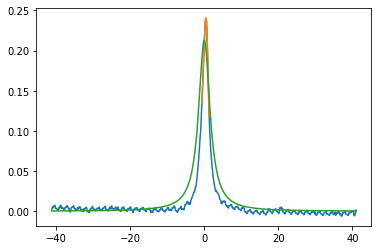

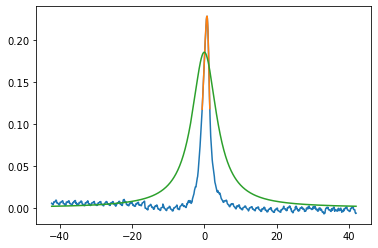

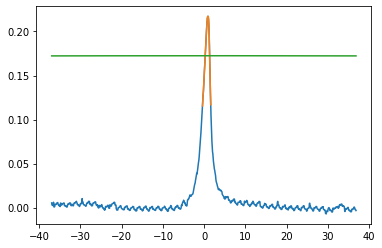

In [172]:
def lor(x, gamma, R): return gamma/(1 + R + x**2)
def linear(x, a, b): return a*x + b
    
G, Rabi, P = [], [], []

for cut in range(len(imd.power)):
    x, y = np.array(imd.freq), np.array(imd.real[cut])
    t = (imd.freq_r[cut] - x)/imd.gamma2[cut]
    
    l, r = imd.HM_indexes(-y)
    ids = range(l, r)
    
    plt.plot(t, y)
    plt.plot(t[ids], y[ids])
    
    HWHM = t[r] - t[l]
    R = (HWHM**2 - 1)
    gamma = max(y)*(1 + R)
    p0 = (gamma, R)
    popt, pcov = curve_fit(lor, t[ids], y[ids], p0=p0)
    
    plt.plot(t, lor(t, *popt))
    plt.show()
    
    G.append(popt[0])
    Rabi.append(popt[1])
    P.append(imd.power[cut])

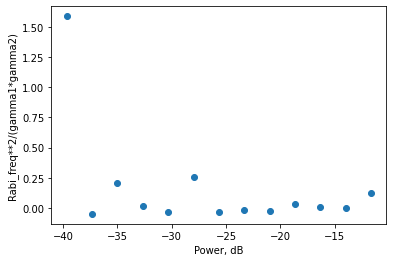

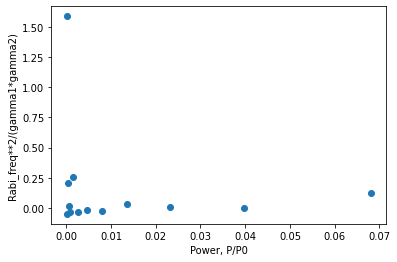

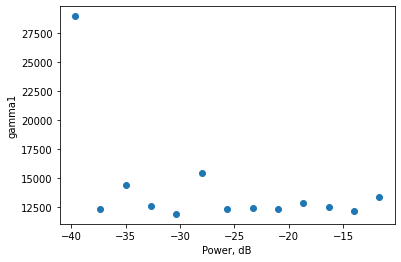

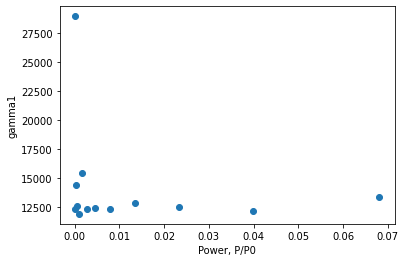

In [177]:
G, Rabi, P = np.array(G), np.array(Rabi), np.array(P)
ids = range(4, len(P) - 5)

plt.scatter(P[ids], Rabi[ids])
plt.xlabel('Power, dB')
plt.ylabel('Rabi_freq**2/(gamma1*gamma2)')
plt.show()

plt.scatter(10.**(0.1*P[ids]), Rabi[ids])
plt.xlabel('Power, P/P0')
plt.ylabel('Rabi_freq**2/(gamma1*gamma2)')
plt.show()

plt.scatter(P[ids], G[ids]*2*np.array(imd.gamma2)[ids])
plt.xlabel('Power, dB')
plt.ylabel('gamma1')
plt.show()

plt.scatter(10.**(0.1*P[ids]), G[ids]*2*np.array(imd.gamma2)[ids])
plt.xlabel('Power, P/P0')
plt.ylabel('gamma1')
plt.show()
